<a href="https://colab.research.google.com/github/AmlanAlok/instacart-2017-project/blob/correct-accuracy/Instacart_2017_XGBoost_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For data manipulation
import pandas as pd    
import xgboost
from sklearn.model_selection import train_test_split
import time

import numpy as np # algebra & calculus
from google.colab import drive
drive.mount('/content/drive/')

%cd 'drive/MyDrive/9-Projects/1-ML-Instacart'


# Garbage Collector to free up memory
import gc                         
gc.enable()  

Mounted at /content/drive/
/content/drive/MyDrive/9-Projects/1-ML-Instacart


Reading input

In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
products = pd.read_csv("products.csv")
orders = pd.read_csv("orders_50.csv")
order_products_prior = pd.read_csv("op_prior_50.csv")
order_products_train = pd.read_csv("op_train_50.csv")
# orders = pd.read_csv("orders_100.csv")
# order_products_prior = pd.read_csv("op_prior_100.csv")
# order_products_train = pd.read_csv("op_train_100.csv")
# orders = pd.read_csv("orders.csv")
# order_products_prior = pd.read_csv("order_products__prior.csv")
# order_products_train = pd.read_csv("order_products__train.csv")

print("aisles: ",aisles.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisles:  (134, 2)
departments:  (21, 2)
orders:  (831792, 7)
products:  (49688, 4)
order_products_prior:  (7882503, 4)
order_products_train:  (334239, 4)


Reducing size of orders for faster computation

In [3]:
# orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac=0.1, random_state=25))] 
orders.shape

(831792, 7)

In [4]:
orders.head(11)
orders[(orders['eval_set']=='train') & (orders['user_id']==1)]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0


Changing some columns from object type to Category

In [5]:
order_products_train[order_products_train['order_id']==1187899]

,order_id,product_id,add_to_cart_order,reordered
116663,1187899,196,1,1
116664,1187899,25133,2,1
116665,1187899,38928,3,1
116666,1187899,26405,4,1
116667,1187899,39657,5,1
116668,1187899,10258,6,1
116669,1187899,13032,7,1
116670,1187899,26088,8,1
116671,1187899,27845,9,0
116672,1187899,49235,10,1


In [6]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

In [7]:
op = orders.merge(order_products_prior, on='order_id', how='inner')
print('op.shape', op.shape)
op.head()

op.shape (7882503, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [8]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7882503 entries, 0 to 7882502
Data columns (total 10 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   eval_set                category
 3   order_number            int64   
 4   order_dow               int64   
 5   order_hour_of_day       int64   
 6   days_since_prior_order  float64 
 7   product_id              int64   
 8   add_to_cart_order       int64   
 9   reordered               int64   
dtypes: category(1), float64(1), int64(8)
memory usage: 608.9 MB


In [9]:
op['reordered'] = op['reordered'].astype('int8')
op['order_dow'] = op['order_dow'].astype('int8')
op['order_hour_of_day'] = op['order_hour_of_day'].astype('int8')
op['add_to_cart_order'] = op['add_to_cart_order'].astype('int8')
op['days_since_prior_order'] = op['days_since_prior_order'].astype('float16')
op['user_id'] = op['user_id'].astype('int32')
op['order_id'] = op['order_id'].astype('int32')

In [10]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7882503 entries, 0 to 7882502
Data columns (total 10 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int64   
 4   order_dow               int8    
 5   order_hour_of_day       int8    
 6   days_since_prior_order  float16 
 7   product_id              int64   
 8   add_to_cart_order       int8    
 9   reordered               int8    
dtypes: category(1), float16(1), int32(2), int64(2), int8(4)
memory usage: 293.2 MB


1. USER PREDICTORS




In [11]:
# Create distinct groups for each user, identify the highest order number in each group

# How many times has a user placed orders?

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
print('user.shape =', user.shape)
print('total users in the prior dataset =', user.shape[0])
user.head()

user.shape = (49999, 1)
total users in the prior dataset = 49999


,u_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [12]:
# Resetting index
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [13]:
# For a given user what is the mean of the reordered column?
# For a user, what is the ratio of reordered item to total items ordered?

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
print('u_reorder.shape', u_reorder.shape)
u_reorder.head()

u_reorder.shape (49999, 2)


,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [14]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

print('user.shape =', user.shape)
user.head()

user.shape = (49999, 3)


,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


2. PRODUCT PREDICTORS

In [15]:
# For each product, count the number of orders in which it was present
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
print('prd.shape =', prd.shape)
prd.head()

prd.shape = (46877, 2)


,product_id,p_total_purchases
0,1,425
1,2,27
2,3,90
3,4,68
4,6,3


In [16]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >260)
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (6378825, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [17]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (4781, 2)


,product_id,p_reorder_ratio
0,1,0.571765
1,10,0.505547
2,25,0.664122
3,34,0.594628
4,45,0.660134


In [18]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

print('prd.shape =', prd.shape)
prd.head()

prd.shape = (46877, 3)


,product_id,p_total_purchases,p_reorder_ratio
0,1,425,0.571765
1,2,27,NaN
2,3,90,NaN
3,4,68,NaN
4,6,3,NaN


In [19]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,425,0.571765
1,2,27,0.000000
2,3,90,0.000000
3,4,68,0.000000
4,6,3,0.000000


3. USER-PRODUCT PREDICTORS

In [20]:
# For a user, counting the number of products they bought of each type

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
1       196                       10
        10258                      9
        10326                      1
        12427                     10
        13032                      3

In [21]:
uxp = uxp.reset_index()
print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (3225069, 3)


,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [22]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
print('times.shape =', times.shape)
times.head()

times.shape = (3225069, 1)


Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

In [23]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders = total_orders.reset_index()
print('total_orders.shape =', total_orders.shape)
total_orders.head()

total_orders.shape = (49999, 2)


,user_id,total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [24]:
# Amongsnt all the orders a user placed, we are finding the order number where 
# a certain product was bought for the first time

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no = first_order_no.reset_index()
print('first_order_no.shape =', first_order_no.shape)
first_order_no.head()

first_order_no.shape = (3225069, 3)


,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [25]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
print('span.shape =', span.shape)
span.head()

span.shape = (3225069, 4)


,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


In [26]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
print('span.shape =', span.shape)
span.head()

span.shape = (3225069, 5)


,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


In [27]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (3225069, 6)


,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9


In [28]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333


In [29]:
# dropping all unrequired columns

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (3225069, 3)


,user_id,product_id,uxp_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [30]:
#Remove temporary DataFrames
del [times, first_order_no, span]

In [31]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio

print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (3225069, 4)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


MERGE ALL FEATURES

In [32]:
# Merging uxp features with the user features

data = uxp.merge(user, on='user_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (3225069, 6)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,1,196,10,1.000000,10,0.694915
1,1,10258,9,1.000000,10,0.694915
2,1,10326,1,0.166667,10,0.694915
3,1,12427,10,1.000000,10,0.694915
4,1,13032,3,0.333333,10,0.694915


In [33]:
# Merge uxp & user features (the new DataFrame) with prd features

data = data.merge(prd, on='product_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (3225069, 8)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,1.000000,10,0.694915,9271,0.788264
1,1,10258,9,1.000000,10,0.694915,469,0.707889
2,1,10326,1,0.166667,10,0.694915,1220,0.618852
3,1,12427,10,1.000000,10,0.694915,1586,0.734552
4,1,13032,3,0.333333,10,0.694915,877,0.638540


In [34]:
# del op, user, prd, uxp
del user, prd, uxp
gc.collect()

100

TRAIN DF

In [35]:
print('orders.shape =', orders.shape)
orders['eval_set'].unique()

orders.shape = (831792, 7)


['prior', 'train', 'test']
Categories (3, object): ['prior', 'test', 'train']

In [36]:
print('op.shape =', op.shape)
op = op.drop(['eval_set', 'order_id', 'add_to_cart_order'], axis=1)
op.head(10)

op.shape = (7882503, 10)


,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,1,2,8,NaN,196,0
1,1,1,2,8,NaN,14084,0
2,1,1,2,8,NaN,12427,0
3,1,1,2,8,NaN,26088,0
4,1,1,2,8,NaN,26405,0
5,1,2,3,7,15.0,196,1
6,1,2,3,7,15.0,10258,0
7,1,2,3,7,15.0,12427,1
8,1,2,3,7,15.0,13176,0
9,1,2,3,7,15.0,26088,1


In [37]:
op['days_since_prior_order'] = op['days_since_prior_order'].fillna(0)
op.head(30)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,1,2,8,0.0,196,0
1,1,1,2,8,0.0,14084,0
2,1,1,2,8,0.0,12427,0
3,1,1,2,8,0.0,26088,0
4,1,1,2,8,0.0,26405,0
5,1,2,3,7,15.0,196,1
6,1,2,3,7,15.0,10258,0
7,1,2,3,7,15.0,12427,1
8,1,2,3,7,15.0,13176,0
9,1,2,3,7,15.0,26088,1


In [38]:
# op = op.groupby(['user_id','product_id'])['reordered'].sum()

# op = op.reset_index()
# # op3 = op3[op3['new_reorder'] > 0]

# # new_reorder = np.where(op3["new_reorder"] > 0, 1, 0)
# op['reordered'] = op['reordered'].apply(lambda x: 0 if x == 0 else 1)
# op.head(20)
# op.shape

In [39]:
opjoin = op.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin.shape =', opjoin.shape)

opjoin.shape = (7882503, 13)


In [40]:
del op

In [41]:
opjoin.head(40)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,1,2,8,0.0,196,0,10,1.000000,10,0.694915,9271,0.788264
1,1,1,2,8,0.0,14084,0,1,0.100000,10,0.694915,4101,0.812729
2,1,1,2,8,0.0,12427,0,10,1.000000,10,0.694915,1586,0.734552
3,1,1,2,8,0.0,26088,0,2,0.200000,10,0.694915,633,0.556082
4,1,1,2,8,0.0,26405,0,2,0.200000,10,0.694915,291,0.395189
5,1,2,3,7,15.0,196,1,10,1.000000,10,0.694915,9271,0.788264
6,1,2,3,7,15.0,10258,0,9,1.000000,10,0.694915,469,0.707889
7,1,2,3,7,15.0,12427,1,10,1.000000,10,0.694915,1586,0.734552
8,1,2,3,7,15.0,13176,0,2,0.222222,10,0.694915,92533,0.833454
9,1,2,3,7,15.0,26088,1,2,0.200000,10,0.694915,633,0.556082


In [42]:
opjoin['reordered'].unique()

array([0, 1], dtype=int8)

In [43]:
opjoin = opjoin.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [44]:
opjoin = opjoin.set_index(['user_id', 'product_id'])
opjoin.head(11)

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                    1          2                  8   
        14084                  1          2                  8   
        12427                  1          2                  8   
        26088                  1          2                  8   
        26405                  1          2                  8   
        196                    2          3                  7   
        10258                  2          3                  7   
        12427                  2          3                  7   
        13176                  2          3                  7   
        26088                  2          3                  7   
        13032                  2          3                  7   

                    days_since_prior_order  reordered  uxp_reorder_ratio  \
user_id product_id                                                         
1       196                            0.0          0           1.000000   
        14084                          0.0          0           0.100000   
        12427                          0.0          0           1.000000   
        26088                          0.0          0           0.200000   
        26405                          0.0          0           0.200000   
        196                           15.0          1           1.000000   
        10258                         15.0          0           1.000000   
        12427                         15.0          1           1.000000   
        13176                         15.0          0           0.222222   
        26088                         15.0          1           0.200000   
        13032                         15.0          0           0.333333   

                    u_reordered_ratio  p_reorder_ratio  
user_id product_id                                      
1       196                  0.694915         0.788264  
        14084                0.694915         0.812729  
        12427                0.694915         0.734552  
        26088                0.694915         0.556082  
        26405                0.694915         0.395189  
        196                  0.694915         0.788264  
        10258                0.694915         0.707889  
        12427                0.694915         0.734552  
        13176                0.694915         0.833454  
        26088                0.694915         0.556082  
        13032                0.694915         0.638540

In [45]:
opjoin.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7882503 entries, (1, 196) to (49999, 10644)
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_number            int64  
 1   order_dow               int8   
 2   order_hour_of_day       int8   
 3   days_since_prior_order  float16
 4   reordered               int8   
 5   uxp_reorder_ratio       float64
 6   u_reordered_ratio       float64
 7   p_reorder_ratio         float64
dtypes: float16(1), float64(3), int64(1), int8(3)
memory usage: 341.0 MB


In [46]:
opjoin.head(20)

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                    1          2                  8   
        14084                  1          2                  8   
        12427                  1          2                  8   
        26088                  1          2                  8   
        26405                  1          2                  8   
        196                    2          3                  7   
        10258                  2          3                  7   
        12427                  2          3                  7   
        13176                  2          3                  7   
        26088                  2          3                  7   
        13032                  2          3                  7   
        196                    3          3                 12   
        12427                  3          3                 12   
        10258                  3          3                 12   
        25133                  3          3                 12   
        30450                  3          3                 12   
        196                    4          4                  7   
        12427                  4          4                  7   
        10258                  4          4                  7   
        25133                  4          4                  7   

                    days_since_prior_order  reordered  uxp_reorder_ratio  \
user_id product_id                                                         
1       196                            0.0          0           1.000000   
        14084                          0.0          0           0.100000   
        12427                          0.0          0           1.000000   
        26088                          0.0          0           0.200000   
        26405                          0.0          0           0.200000   
        196                           15.0          1           1.000000   
        10258                         15.0          0           1.000000   
        12427                         15.0          1           1.000000   
        13176                         15.0          0           0.222222   
        26088                         15.0          1           0.200000   
        13032                         15.0          0           0.333333   
        196                           21.0          1           1.000000   
        12427                         21.0          1           1.000000   
        10258                         21.0          1           1.000000   
        25133                         21.0          0           1.000000   
        30450                         21.0          0           0.125000   
        196                           29.0          1           1.000000   
        12427                         29.0          1           1.000000   
        10258                         29.0          1           1.000000   
        25133                         29.0          1           1.000000   

                    u_reordered_ratio  p_reorder_ratio  
user_id product_id                                      
1       196                  0.694915         0.788264  
        14084                0.694915         0.812729  
        12427                0.694915         0.734552  
        26088                0.694915         0.556082  
        26405                0.694915         0.395189  
        196                  0.694915         0.788264  
        10258                0.694915         0.707889  
        12427                0.694915         0.734552  
        13176                0.694915         0.833454  
        26088                0.694915         0.556082  
        13032                0.694915         0.638540  
        196                  0.694915         0.788264  
        12427                0.694915         0.734552  
        10258                0.694915  

TEST DF 

In [47]:
order_products_train = order_products_train[order_products_train['reordered']==1]
print('order_products_train.shape =', order_products_train)
op_test = orders.merge(order_products_train, on='order_id', how='inner')
print('op_test.shape', op_test.shape)
op_test.head(20)

order_products_train.shape =         order_id  product_id  add_to_cart_order  reordered
3             38       21616                  4          1
9             96       20574                  1          1
11            96       40706                  3          1
13            96       27966                  5          1
14            96       24489                  6          1
...          ...         ...                ...        ...
334230   3420996       24035                  3          1
334233   3420996       14947                  6          1
334234   3420996        2086                  7          1
334236   3420996       27423                  9          1
334237   3420996       12125                 10          1

[201191 rows x 4 columns]
op_test.shape (201191, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1187899,1,train,11,4,8,14.0,196,1,1
1,1187899,1,train,11,4,8,14.0,25133,2,1
2,1187899,1,train,11,4,8,14.0,38928,3,1
3,1187899,1,train,11,4,8,14.0,26405,4,1
4,1187899,1,train,11,4,8,14.0,39657,5,1
5,1187899,1,train,11,4,8,14.0,10258,6,1
6,1187899,1,train,11,4,8,14.0,13032,7,1
7,1187899,1,train,11,4,8,14.0,26088,8,1
8,1187899,1,train,11,4,8,14.0,49235,10,1
9,1187899,1,train,11,4,8,14.0,46149,11,1


In [48]:
op_test = op_test.drop(['eval_set', 'order_id', 'add_to_cart_order'], axis=1)
op_test.head(15)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,11,4,8,14.0,196,1
1,1,11,4,8,14.0,25133,1
2,1,11,4,8,14.0,38928,1
3,1,11,4,8,14.0,26405,1
4,1,11,4,8,14.0,39657,1
5,1,11,4,8,14.0,10258,1
6,1,11,4,8,14.0,13032,1
7,1,11,4,8,14.0,26088,1
8,1,11,4,8,14.0,49235,1
9,1,11,4,8,14.0,46149,1


In [49]:
# op_test[op_test['user_id']==1]

In [50]:
expected_y_df = op_test
expected_y_df = expected_y_df.rename(columns={"reordered": "expected_y"})
print('expected_y_df.shape =', expected_y_df.shape)
expected_y_df.head()

expected_y_df.shape = (201191, 7)


,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,expected_y
0,1,11,4,8,14.0,196,1
1,1,11,4,8,14.0,25133,1
2,1,11,4,8,14.0,38928,1
3,1,11,4,8,14.0,26405,1
4,1,11,4,8,14.0,39657,1


In [51]:
op_test = op_test.drop(['product_id','reordered'], axis=1)
op_test.head(12)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,11,4,8,14.0
1,1,11,4,8,14.0
2,1,11,4,8,14.0
3,1,11,4,8,14.0
4,1,11,4,8,14.0
5,1,11,4,8,14.0
6,1,11,4,8,14.0
7,1,11,4,8,14.0
8,1,11,4,8,14.0
9,1,11,4,8,14.0


In [52]:
op_test = op_test.drop_duplicates()

In [53]:
op_test.head()

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,11,4,8,14.0
10,2,15,1,11,30.0
22,5,5,0,11,6.0
26,7,21,2,11,6.0
34,8,4,1,14,10.0


In [54]:
user_prd_details = opjoin.drop(['order_number',	'order_dow', 'order_hour_of_day',	'days_since_prior_order',	'reordered'], axis=1)
user_prd_details.head()

uxp_reorder_ratio  u_reordered_ratio  p_reorder_ratio
user_id product_id                                                       
1       196                       1.0           0.694915         0.788264
        14084                     0.1           0.694915         0.812729
        12427                     1.0           0.694915         0.734552
        26088                     0.2           0.694915         0.556082
        26405                     0.2           0.694915         0.395189

In [55]:
user_prd_details = user_prd_details.drop_duplicates()
user_prd_details.head(20)

uxp_reorder_ratio  u_reordered_ratio  p_reorder_ratio
user_id product_id                                                       
1       196                  1.000000           0.694915         0.788264
        14084                0.100000           0.694915         0.812729
        12427                1.000000           0.694915         0.734552
        26088                0.200000           0.694915         0.556082
        26405                0.200000           0.694915         0.395189
        10258                1.000000           0.694915         0.707889
        13176                0.222222           0.694915         0.833454
        13032                0.333333           0.694915         0.638540
        25133                1.000000           0.694915         0.737166
        30450                0.125000           0.694915         0.594628
        10326                0.166667           0.694915         0.618852
        17122                0.166667           0.694915         0.655302
        41787                0.166667           0.694915         0.651804
        46149                1.000000           0.694915         0.804134
        49235                0.666667           0.694915         0.773240
        39657                1.000000           0.694915         0.758176
        38928                1.000000           0.694915         0.828919
        35951                1.000000           0.694915         0.751962
2       32792                0.642857           0.476923         0.606414
        47766                0.285714           0.476923         0.760025

In [56]:
user_prd_details = user_prd_details.reset_index()
user_prd_details.head(20)

,user_id,product_id,uxp_reorder_ratio,u_reordered_ratio,p_reorder_ratio
0,1,196,1.000000,0.694915,0.788264
1,1,14084,0.100000,0.694915,0.812729
2,1,12427,1.000000,0.694915,0.734552
3,1,26088,0.200000,0.694915,0.556082
4,1,26405,0.200000,0.694915,0.395189
5,1,10258,1.000000,0.694915,0.707889
6,1,13176,0.222222,0.694915,0.833454
7,1,13032,0.333333,0.694915,0.638540
8,1,25133,1.000000,0.694915,0.737166
9,1,30450,0.125000,0.694915,0.594628


In [57]:
opjoin_test = user_prd_details.merge(op_test, on='user_id', how='inner')
opjoin_test.head(20)

,user_id,product_id,uxp_reorder_ratio,u_reordered_ratio,p_reorder_ratio,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,196,1.000000,0.694915,0.788264,11,4,8,14.0
1,1,14084,0.100000,0.694915,0.812729,11,4,8,14.0
2,1,12427,1.000000,0.694915,0.734552,11,4,8,14.0
3,1,26088,0.200000,0.694915,0.556082,11,4,8,14.0
4,1,26405,0.200000,0.694915,0.395189,11,4,8,14.0
5,1,10258,1.000000,0.694915,0.707889,11,4,8,14.0
6,1,13176,0.222222,0.694915,0.833454,11,4,8,14.0
7,1,13032,0.333333,0.694915,0.638540,11,4,8,14.0
8,1,25133,1.000000,0.694915,0.737166,11,4,8,14.0
9,1,30450,0.125000,0.694915,0.594628,11,4,8,14.0


In [58]:
# opjoin_test = op_test.merge(data, on=['user_id'], how='right')
# print('opjoin_test.shape =', opjoin_test.shape)


In [59]:
# opjoin.head(20)

In [60]:
# opjoin_test = opjoin_test.drop('reordered', axis=1)
# opjoin_test.head(12)

In [61]:
# opjoin_test = opjoin_test.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [62]:
opjoin_test = opjoin_test.set_index(['user_id', 'product_id'])
opjoin_test.head(20)

uxp_reorder_ratio  u_reordered_ratio  p_reorder_ratio  \
user_id product_id                                                          
1       196                  1.000000           0.694915         0.788264   
        14084                0.100000           0.694915         0.812729   
        12427                1.000000           0.694915         0.734552   
        26088                0.200000           0.694915         0.556082   
        26405                0.200000           0.694915         0.395189   
        10258                1.000000           0.694915         0.707889   
        13176                0.222222           0.694915         0.833454   
        13032                0.333333           0.694915         0.638540   
        25133                1.000000           0.694915         0.737166   
        30450                0.125000           0.694915         0.594628   
        10326                0.166667           0.694915         0.618852   
        17122                0.166667           0.694915         0.655302   
        41787                0.166667           0.694915         0.651804   
        46149                1.000000           0.694915         0.804134   
        49235                0.666667           0.694915         0.773240   
        39657                1.000000           0.694915         0.758176   
        38928                1.000000           0.694915         0.828919   
        35951                1.000000           0.694915         0.751962   
2       32792                0.642857           0.476923         0.606414   
        47766                0.285714           0.476923         0.760025   

                    order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                   11          4                  8   
        14084                 11          4                  8   
        12427                 11          4                  8   
        26088                 11          4                  8   
        26405                 11          4                  8   
        10258                 11          4                  8   
        13176                 11          4                  8   
        13032                 11          4                  8   
        25133                 11          4                  8   
        30450                 11          4                  8   
        10326                 11          4                  8   
        17122                 11          4                  8   
        41787                 11          4                  8   
        46149                 11          4                  8   
        49235                 11          4                  8   
        39657                 11          4                  8   
        38928                 11          4                  8   
        35951                 11          4                  8   
2       32792                 15          1                 11   
        47766                 15          1                 11   

                    days_since_prior_order  
user_id product_id                          
1       196                           14.0  
        14084                         14.0  
        12427                         14.0  
        26088                         14.0  
        26405                         14.0  
        10258                         14.0  
        13176                         14.0  
        13032                         14.0  
        25133                         14.0  
        30450                         14.0  
        10326                         14.0  
        17122                         14.0  
        41787                         14.0  
        46149                         14.0  
        49235                         14.0  
        39657                         14.0  
        38928                         14.0  
        35951    

In [63]:
opjoin_test = opjoin_test[['order_number', 'order_dow',	'order_hour_of_day',	'days_since_prior_order', 'uxp_reorder_ratio',	'u_reordered_ratio',	'p_reorder_ratio']]
opjoin_test.head()

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                   11          4                  8   
        14084                 11          4                  8   
        12427                 11          4                  8   
        26088                 11          4                  8   
        26405                 11          4                  8   

                    days_since_prior_order  uxp_reorder_ratio  \
user_id product_id                                              
1       196                           14.0                1.0   
        14084                         14.0                0.1   
        12427                         14.0                1.0   
        26088                         14.0                0.2   
        26405                         14.0                0.2   

                    u_reordered_ratio  p_reorder_ratio  
user_id product_id                                      
1       196                  0.694915         0.788264  
        14084                0.694915         0.812729  
        12427                0.694915         0.734552  
        26088                0.694915         0.556082  
        26405                0.694915         0.395189

In [64]:
opjoin_test.shape

(1653204, 7)

Build Model

In [65]:
import xgboost
from sklearn.model_selection import train_test_split
# data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)
# data_train.head()

In [66]:
opjoin.head()

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                    1          2                  8   
        14084                  1          2                  8   
        12427                  1          2                  8   
        26088                  1          2                  8   
        26405                  1          2                  8   

                    days_since_prior_order  reordered  uxp_reorder_ratio  \
user_id product_id                                                         
1       196                            0.0          0                1.0   
        14084                          0.0          0                0.1   
        12427                          0.0          0                1.0   
        26088                          0.0          0                0.2   
        26405                          0.0          0                0.2   

                    u_reordered_ratio  p_reorder_ratio  
user_id product_id                                      
1       196                  0.694915         0.788264  
        14084                0.694915         0.812729  
        12427                0.694915         0.734552  
        26088                0.694915         0.556082  
        26405                0.694915         0.395189

In [67]:
########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(opjoin.drop('reordered', axis=1), opjoin.reordered,
                                                    test_size=0.2, random_state=42)

[15:47:32] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-logloss:0.656557
[10]	train-logloss:0.476645
[20]	train-logloss:0.424275
[30]	train-logloss:0.40225
[40]	train-logloss:0.392555
[50]	train-logloss:0.387166
[60]	train-logloss:0.383391
[70]	train-logloss:0.379091
[79]	train-logloss:0.376655


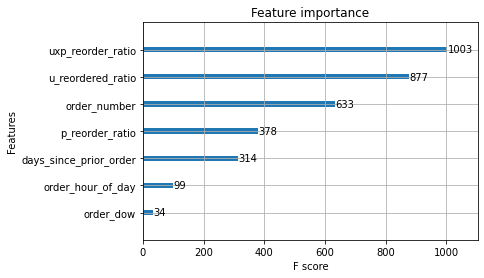

In [68]:
############################
## INITIATE AND TRAIN MODEL
############################

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [69]:
del [X_train, X_val, y_train, y_val]
gc.collect()

72

In [70]:
opjoin_test.head()

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                   11          4                  8   
        14084                 11          4                  8   
        12427                 11          4                  8   
        26088                 11          4                  8   
        26405                 11          4                  8   

                    days_since_prior_order  uxp_reorder_ratio  \
user_id product_id                                              
1       196                           14.0                1.0   
        14084                         14.0                0.1   
        12427                         14.0                1.0   
        26088                         14.0                0.2   
        26405                         14.0                0.2   

                    u_reordered_ratio  p_reorder_ratio  
user_id product_id                                      
1       196                  0.694915         0.788264  
        14084                0.694915         0.812729  
        12427                0.694915         0.734552  
        26088                0.694915         0.556082  
        26405                0.694915         0.395189

In [71]:
opjoin.head()

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                    1          2                  8   
        14084                  1          2                  8   
        12427                  1          2                  8   
        26088                  1          2                  8   
        26405                  1          2                  8   

                    days_since_prior_order  reordered  uxp_reorder_ratio  \
user_id product_id                                                         
1       196                            0.0          0                1.0   
        14084                          0.0          0                0.1   
        12427                          0.0          0                1.0   
        26088                          0.0          0                0.2   
        26405                          0.0          0                0.2   

                    u_reordered_ratio  p_reorder_ratio  
user_id product_id                                      
1       196                  0.694915         0.788264  
        14084                0.694915         0.812729  
        12427                0.694915         0.734552  
        26088                0.694915         0.556082  
        26405                0.694915         0.395189

In [ ]:
opjoin 

In [72]:
pred = xgboost.DMatrix(opjoin_test)

prediction = opjoin_test.reset_index()
prediction = prediction[['product_id', 'user_id']]

prediction["reordered_predicted"] = (bst.predict(pred) > 0.15).astype(int)
print('prediction.shape =', prediction.shape)
prediction.head(30)

prediction.shape = (1653204, 3)


,product_id,user_id,reordered_predicted
0,196,1,1
1,14084,1,1
2,12427,1,1
3,26088,1,1
4,26405,1,1
5,10258,1,1
6,13176,1,1
7,13032,1,1
8,25133,1,1
9,30450,1,1


In [ ]:
# prediction.head(60)

In [142]:
tally = pd.merge(prediction, expected_y_df, on=['user_id', 'product_id'], how='left')
tally.head()

,product_id,user_id,reordered_predicted,order_number,order_dow,order_hour_of_day,days_since_prior_order,expected_y
0,196,1,1,11.0,4.0,8.0,14.0,1.0
1,14084,1,1,NaN,NaN,NaN,NaN,NaN
2,12427,1,1,NaN,NaN,NaN,NaN,NaN
3,26088,1,1,11.0,4.0,8.0,14.0,1.0
4,26405,1,1,11.0,4.0,8.0,14.0,1.0


In [145]:
tally['expected_y'] = tally['expected_y'].fillna(value=0)

In [125]:
# tally = tally[tally['expected_y']==1.0]

In [147]:
tally.head(40)

,product_id,user_id,reordered_predicted,order_number,order_dow,order_hour_of_day,days_since_prior_order,expected_y
0,196,1,1,11.0,4.0,8.0,14.0,1.0
1,14084,1,1,NaN,NaN,NaN,NaN,0.0
2,12427,1,1,NaN,NaN,NaN,NaN,0.0
3,26088,1,1,11.0,4.0,8.0,14.0,1.0
4,26405,1,1,11.0,4.0,8.0,14.0,1.0
5,10258,1,1,11.0,4.0,8.0,14.0,1.0
6,13176,1,1,NaN,NaN,NaN,NaN,0.0
7,13032,1,1,11.0,4.0,8.0,14.0,1.0
8,25133,1,1,11.0,4.0,8.0,14.0,1.0
9,30450,1,1,NaN,NaN,NaN,NaN,0.0


In [148]:
compare = np.where(tally["reordered_predicted"] == tally["expected_y"], True, False)

tally['compare'] = compare
tally.head()

,product_id,user_id,reordered_predicted,order_number,order_dow,order_hour_of_day,days_since_prior_order,expected_y,compare
0,196,1,1,11.0,4.0,8.0,14.0,1.0,True
1,14084,1,1,NaN,NaN,NaN,NaN,0.0,False
2,12427,1,1,NaN,NaN,NaN,NaN,0.0,False
3,26088,1,1,11.0,4.0,8.0,14.0,1.0,True
4,26405,1,1,11.0,4.0,8.0,14.0,1.0,True


In [149]:
tally.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1653204 entries, 0 to 1653203
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   product_id              1653204 non-null  int64  
 1   user_id                 1653204 non-null  int64  
 2   reordered_predicted     1653204 non-null  int64  
 3   order_number            176534 non-null   float64
 4   order_dow               176534 non-null   float64
 5   order_hour_of_day       176534 non-null   float64
 6   days_since_prior_order  176534 non-null   float64
 7   expected_y              1653204 non-null  float64
 8   compare                 1653204 non-null  bool   
dtypes: bool(1), float64(5), int64(3)
memory usage: 115.1 MB


In [150]:
true_count = tally['compare'].sum()
true_count

241257

In [151]:
false_count = len(tally['compare'])- true_count
false_count

1411947

In [152]:
accuracy = (true_count/(len(tally['compare'])))*100
print('Accuracy =', accuracy, '%')

Accuracy = 14.593298830634332 %


In [153]:
# tally.head(60)

In [155]:
# opjoin_test = opjoin_test.reset_index()

In [ ]:
# opjoin_test[((opjoin_test['user_id']==7) & opjoin_test['product_id']==37999)]

In [ ]:
# expected_y_df[expected_y_df['user_id']==7]

In [ ]:
# opjoin = opjoin.reset_index()

In [ ]:
# opjoin[(opjoin['user_id']==7) & (opjoin['product_id']==37999)]

In [ ]:
# prediction[(prediction['user_id']==7) & (prediction['product_id']==37999)]